# Asian Option Numerical Experiments

The value of the Asian option at time 0 can then be written as the actualized expected payoﬀ at time T. We aim to approximate C(0) using various lattice rules as in https://epubs.siam.org/doi/epdf/10.1137/06065074X.


Authors: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com), Anders Pride (apride@hawk.illinoistech.edu) 

In [101]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

In [102]:
def calculate_w_k(brownian, point):
    return (brownian.a @ stats.norm.ppf(point).T).T

def calculate_payoff(w_k, brownian, dimension, start_price, interest_rate, volatility, t_final, strike_price):
    stock_path = (start_price * np.exp(((interest_rate - volatility ** 2 / 2.) * brownian.time_vec) + volatility * w_k))
    payoff = np.maximum((np.sum(stock_path) / dimension) - strike_price, 0)
    return payoff

In [103]:
S_0 = 100
r = 0.1
sigma = 0.2
T = 1
K = 100
d = 100

num_vectors = 3
replications = 16
n = 2 ** 20

vectors = ['2exp20_9125dim_new_lattice_rule.txt', 'KuoPODweights.txt', 'kuo.lattice-33002-1024-1048576.9125.txt']

In [104]:
samplers = np.empty((num_vectors, replications), dtype = object)
brownian = qp.BrownianMotion(qp.Lattice(dimension = d))

for num_vec in range(num_vectors):
    for replicate in range(replications):
        samplers[num_vec][replicate] = qp.Lattice(dimension = d, generating_vector = 'lattice_vector/' + vectors[num_vec])

In [105]:
samples = np.empty((num_vectors, replications, n, d))
results = np.empty((num_vectors, replications, n))

In [6]:
for num_vec in range(num_vectors):
    for replicate in range(replications):
        samples[num_vec][replicate] = samplers[num_vec][replicate].gen_samples(n)

In [7]:
for num_vec in tqdm(range(num_vectors)):
    for replicate in tqdm(range(replications)):
        for i in range(n):
            w_k = calculate_w_k(brownian = brownian, point = samples[num_vec][replicate][i])
            results[num_vec][replicate][i] = calculate_payoff(w_k = w_k, brownian = brownian, dimension = d, start_price = S_0, interest_rate = r, volatility = sigma, t_final = T, strike_price = K)

100%|██████████| 3/3 [2:30:07<00:00, 3002.51s/it]


In [8]:
results *= np.exp(-1 * r * T)

In [ ]:
integrals = np.empty((num_vectors, replications, n))
for num_vec in range(num_vectors):
    for replicate in range(replications):
        integrals[num_vec][replicate] = np.cumsum(results[num_vec][replicate]) / np.arange(1, n + 1)

In [ ]:
np.save('option_experiment/integrals', integrals)

In [20]:
standard_errors = np.empty((num_vectors, n))

for num_vec in range(num_vectors):
    for sample_num in range(n):
        standard_errors[num_vec][sample_num] = stats.sem(integrals[num_vec][:, sample_num])

In [98]:
np.save('option_experiment/standard_errors', standard_errors)

## Monte Carlo

In [ ]:
monte_carlo_samples = np.empty((replications, n, d))
for replicate in range(replications):
    monte_carlo_samples[replicate] = qp.IIDStdUniform(dimension = d).gen_samples(n)

mc_results = np.empty((replications, n))

In [90]:
for replicate in tqdm(range(replications)):
    for i in range(n):
        w_k = calculate_w_k(brownian = brownian, point = monte_carlo_samples[replicate][i])
        mc_results[replicate][i] = calculate_payoff(w_k = w_k, brownian = brownian, dimension = d, start_price = S_0, interest_rate = r, volatility = sigma, t_final = T, strike_price = K)

100%|██████████| 16/16 [32:46<00:00, 122.90s/it]


In [92]:
mc_results *= np.exp(-1 * r * T)
mc_integrals = np.empty((replications, n))
for replicate in range(replications):
    mc_integrals[replicate] = np.cumsum(mc_results[replicate]) / np.arange(1, n + 1)

In [93]:
np.save('option_experiment/mc_integrals', mc_integrals)

In [94]:
mc_standard_errors = np.empty(n)
for sample_num in range(n):
    mc_standard_errors[sample_num] = stats.sem(mc_integrals[:, sample_num])

In [97]:
np.save('option_experiment/mc_standard_errors', mc_standard_errors)

## Kronecker

In [108]:
alpha = np.loadtxt('kron_vector/d100_n2^17_1e5alpha.txt')

In [109]:
kronecker_samplers = np.empty(replications, dtype = object)
for replicate in range(replications):
    kronecker_samplers[replicate] = qp.Kronecker(dimension = d, alpha = alpha, randomize = True)

In [112]:
n_small = 2 ** 17

In [113]:
kronecker_samples = np.empty((replications, n_small, d))
kronecker_results = np.empty((replications, n_small))

In [114]:
for replicate in range(replications):
    kronecker_samples[replicate] = kronecker_samplers[replicate].gen_samples(n_small)

In [115]:
for replicate in tqdm(range(replications)):
    for i in range(n_small):
        w_k = calculate_w_k(brownian = brownian, point = kronecker_samples[replicate][i])
        kronecker_results[replicate][i] = calculate_payoff(w_k = w_k, brownian = brownian, dimension = d, start_price = S_0, interest_rate = r, volatility = sigma, t_final = T, strike_price = K)

100%|██████████| 16/16 [04:31<00:00, 16.98s/it]


In [116]:
kronecker_results *= np.exp(-1 * r * T)
kronecker_integrals = np.empty((replications, n_small))
for replicate in range(replications):
    kronecker_integrals[replicate] = np.cumsum(kronecker_results[replicate]) / np.arange(1, n_small + 1)
np.save('option_experiment/kronecker_integrals', kronecker_integrals)


kronecker_standard_errors = np.empty(n_small)
for sample_num in range(n_small):
    kronecker_standard_errors[sample_num] = stats.sem(kronecker_integrals[:, sample_num])

np.save('option_experiment/kronecker_standard_errors', kronecker_standard_errors)

## Plots

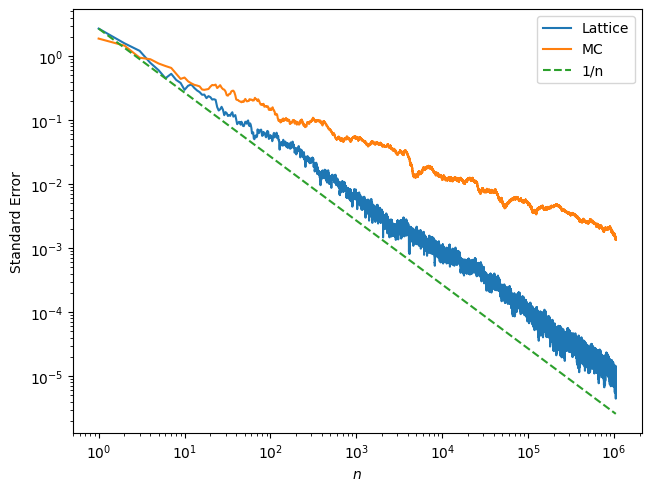

In [95]:
fig, ax = plt.subplots(layout = "constrained")
ax.loglog(np.arange(1, n + 1), standard_errors[0], label = 'Lattice')
ax.loglog(np.arange(1, n + 1), mc_standard_errors, label = 'MC')
ax.plot(np.arange(1, n + 1), standard_errors[0][0] / np.arange(1, n + 1), label = '1/n', linestyle = '--')
ax.set_xlabel('$n$')
ax.set_ylabel('Standard Error')
ax.legend();

In [35]:
averaged_integrals = np.empty((num_vectors, n))

In [38]:
for num_vec in range(num_vectors):
    for sample_num in range(n):
        averaged_integrals[num_vec][sample_num] = np.mean(integrals[num_vec][:, sample_num])

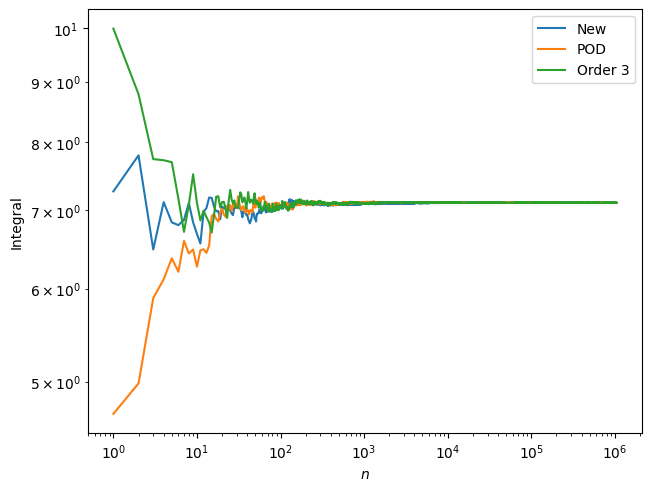

In [ ]:
fig, ax = plt.subplots(layout = "constrained")
ax.loglog(np.arange(1, n + 1), averaged_integrals[0], label = 'New')
ax.loglog(np.arange(1, n + 1), averaged_integrals[1], label = 'POD')
ax.loglog(np.arange(1, n + 1), averaged_integrals[2], label = 'Order 3')
ax.set_xlabel('$n$')
ax.set_ylabel('Integral')
ax.legend();